In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    accuracy_score, precision_recall_fscore_support,
    cohen_kappa_score
)

from src.data_utils import load_data, load_batch_images, DIAGNOSIS_LABELS
from src.model_utils import load_trained_model, predict_batch, CLASS_NAMES

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports successful!")

✓ Imports successful!


## 1. Load Model and Data

In [2]:
# Load the trained model
model = load_trained_model('../model/model.h5')

# Load test data
train_df, test_df = load_data('../data')

print(f"Test samples: {len(test_df)}")
print(f"Model loaded and ready!")

Loading model from ../model/model.h5...
Model loaded successfully!
Test samples: 733
Model loaded and ready!


## 2. Generate Predictions on Test Set

This may take a few minutes as we process all test images...

In [3]:
print("Loading test images and generating predictions...")
print("This will take a few minutes.\n")

# Load all test images
test_image_ids = test_df['id_code'].tolist()
test_images = load_batch_images(test_image_ids, '../data/test_images')

print(f"Loaded {len(test_images)} images")

# Generate predictions
predictions = predict_batch(model, test_images)

# Extract predictions and confidences
y_true = test_df['diagnosis'].values[:len(predictions)]
y_pred = np.array([p['predicted_class'] for p in predictions])
confidences = np.array([p['confidence'] for p in predictions])

print(f"\n✓ Generated {len(predictions)} predictions")
print(f"Average confidence: {confidences.mean():.3f}")

Loading test images and generating predictions...
This will take a few minutes.

Loaded 731 images

✓ Generated 731 predictions
Average confidence: 0.925


## 3. Overall Performance Metrics

In [4]:
# Calculate overall metrics
accuracy = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred, weights='quadratic')

print("="*60)
print("OVERALL MODEL PERFORMANCE")
print("="*60)
print(f"\nOverall Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"Cohen's Kappa Score: {kappa:.3f}")

# Simple explanation
correct_out_of_10 = int(accuracy * 10)
print(f"\nIn simple terms: The model gets it right about {correct_out_of_10} out of 10 times.")

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

print("\n" + "="*60)
print("PERFORMANCE BY DISEASE SEVERITY")
print("="*60)

metrics_df = pd.DataFrame({
    'Class': [f"Class {i}: {CLASS_NAMES[i]}" for i in range(len(CLASS_NAMES))],
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support.astype(int)
})

print(metrics_df.to_string(index=False))

# Save metrics
metrics_df.to_csv('../outputs/analysis/model_performance_metrics.csv', index=False)
print("\n✓ Saved: outputs/analysis/model_performance_metrics.csv")

OVERALL MODEL PERFORMANCE

Overall Accuracy: 0.725 (72.5%)
Cohen's Kappa Score: 0.662

In simple terms: The model gets it right about 7 out of 10 times.

PERFORMANCE BY DISEASE SEVERITY
                    Class  Precision   Recall  F1-Score  Support
           Class 0: No DR   0.862259 0.841398  0.851701      372
            Class 1: Mild   0.490196 0.396825  0.438596       63
        Class 2: Moderate   0.605263 0.813131  0.693966      198
          Class 3: Severe   0.733333 0.297297  0.423077       37
Class 4: Proliferative DR   0.555556 0.327869  0.412371       61

✓ Saved: outputs/analysis/model_performance_metrics.csv


## 4. Confusion Matrix

Shows where the model makes mistakes

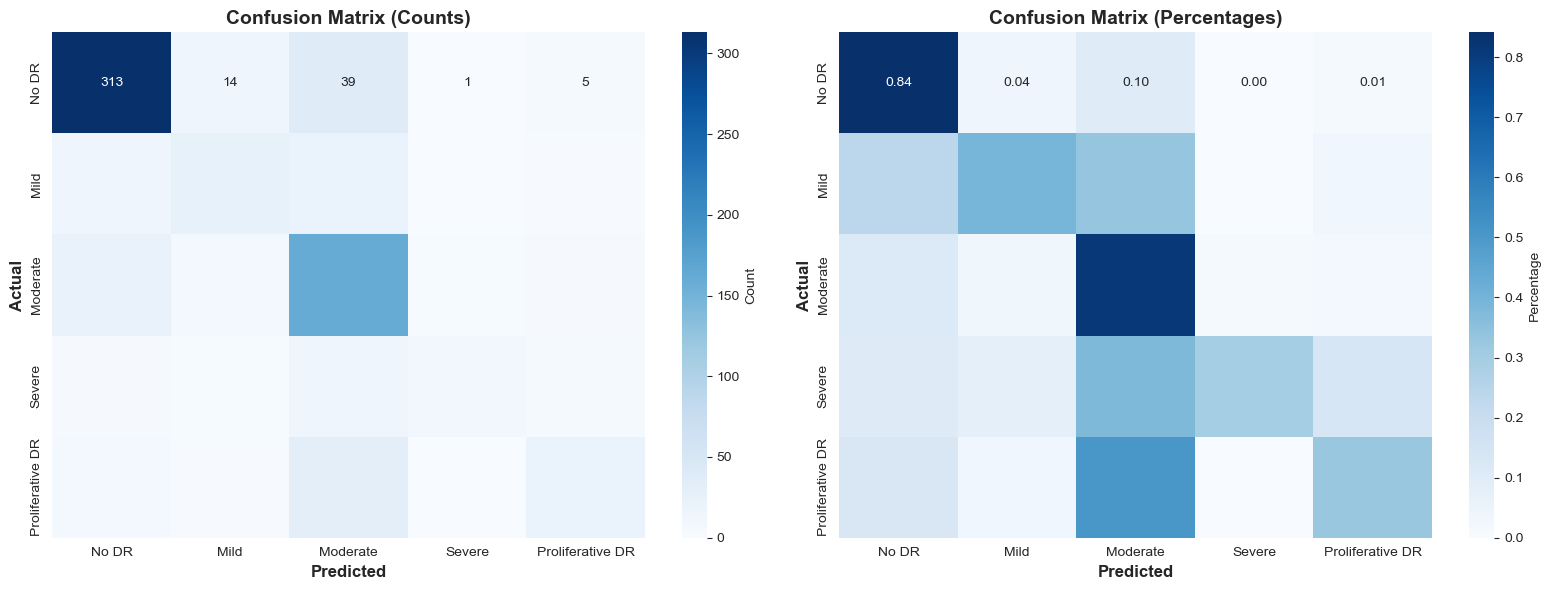

✓ Saved: outputs/figures/confusion_matrix.png


In [5]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
ax1.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

# Normalized (percentages)
ax2 = axes[1]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax2,
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Percentage'})
ax2.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax2.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax2.set_title('Confusion Matrix (Percentages)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: outputs/figures/confusion_matrix.png")

## 5. Per-Class Performance Visualization

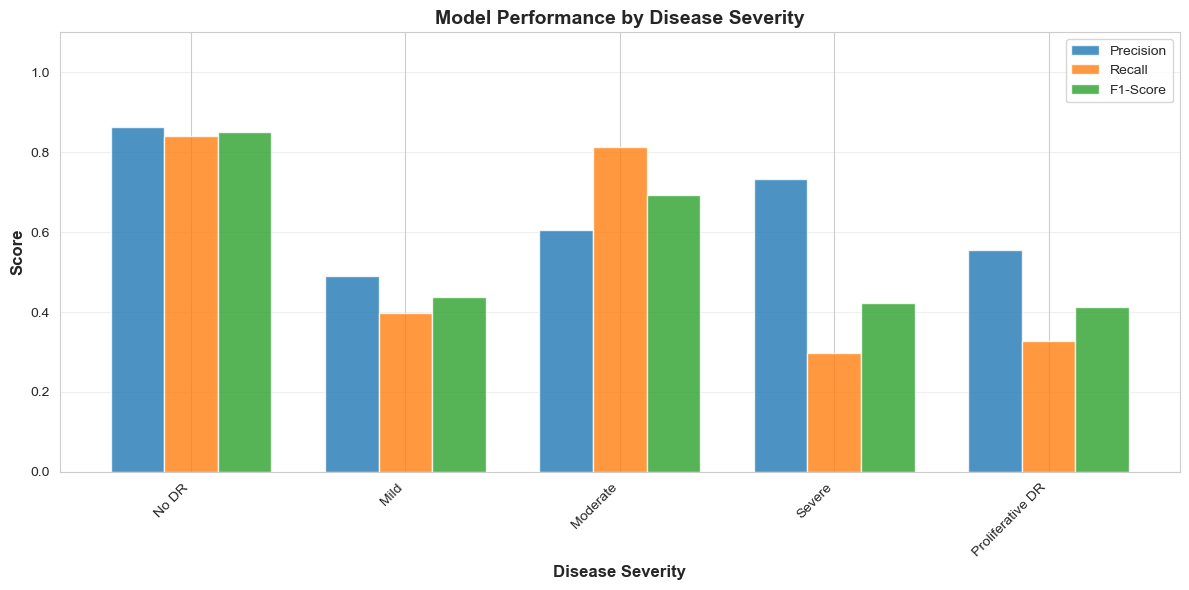

✓ Saved: outputs/figures/per_class_performance.png


In [6]:
# Create bar chart for per-class performance
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(CLASS_NAMES))
width = 0.25

bars1 = ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
bars2 = ax.bar(x, recall, width, label='Recall', alpha=0.8)
bars3 = ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Disease Severity', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance by Disease Severity', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(CLASS_NAMES, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/per_class_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: outputs/figures/per_class_performance.png")

## 6. Confidence Distribution Analysis

Confidence Statistics:
Average confidence: 0.925
Median confidence: 0.988
Minimum confidence: 0.376
Maximum confidence: 1.000

Average confidence (correct predictions): 0.948
Average confidence (incorrect predictions): 0.866

Confidence Distribution:
  High confidence (≥90%): 556 predictions (76.1%)
  Medium confidence (70-90%): 106 predictions (14.5%)
  Low confidence (<70%): 69 predictions (9.4%)


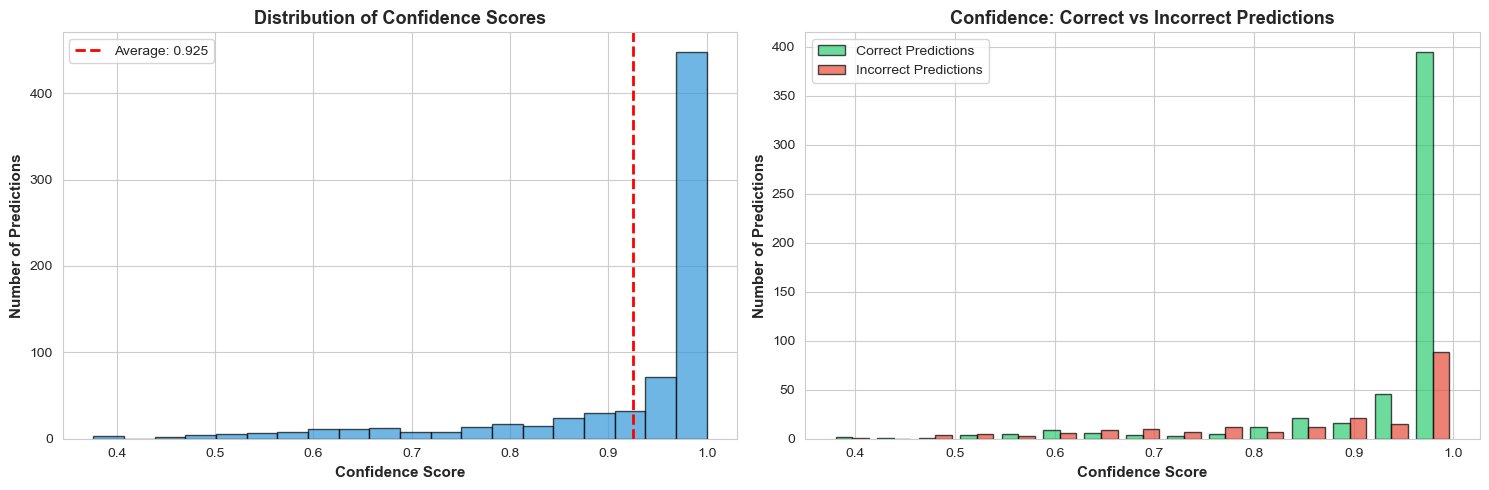


✓ Saved: outputs/figures/confidence_distribution.png


In [7]:
# Analyze confidence levels
print("Confidence Statistics:")
print("="*50)
print(f"Average confidence: {confidences.mean():.3f}")
print(f"Median confidence: {np.median(confidences):.3f}")
print(f"Minimum confidence: {confidences.min():.3f}")
print(f"Maximum confidence: {confidences.max():.3f}")

# Confidence by correctness
correct_mask = (y_true == y_pred)
confidence_correct = confidences[correct_mask]
confidence_incorrect = confidences[~correct_mask]

print(f"\nAverage confidence (correct predictions): {confidence_correct.mean():.3f}")
print(f"Average confidence (incorrect predictions): {confidence_incorrect.mean():.3f}")

# Confidence level breakdown
high_conf = (confidences >= 0.9).sum()
med_conf = ((confidences >= 0.7) & (confidences < 0.9)).sum()
low_conf = (confidences < 0.7).sum()

print(f"\nConfidence Distribution:")
print(f"  High confidence (≥90%): {high_conf} predictions ({high_conf/len(confidences)*100:.1f}%)")
print(f"  Medium confidence (70-90%): {med_conf} predictions ({med_conf/len(confidences)*100:.1f}%)")
print(f"  Low confidence (<70%): {low_conf} predictions ({low_conf/len(confidences)*100:.1f}%)")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of all confidences
ax1 = axes[0]
ax1.hist(confidences, bins=20, color='#3498db', alpha=0.7, edgecolor='black')
ax1.axvline(confidences.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Average: {confidences.mean():.3f}')
ax1.set_xlabel('Confidence Score', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Predictions', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Confidence Scores', fontsize=13, fontweight='bold')
ax1.legend()

# Confidence comparison: correct vs incorrect
ax2 = axes[1]
ax2.hist([confidence_correct, confidence_incorrect], bins=15, 
         label=['Correct Predictions', 'Incorrect Predictions'],
         color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
ax2.set_xlabel('Confidence Score', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Predictions', fontsize=11, fontweight='bold')
ax2.set_title('Confidence: Correct vs Incorrect Predictions', fontsize=13, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.savefig('../outputs/figures/confidence_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: outputs/figures/confidence_distribution.png")

## 7. Error Analysis

Understand what types of mistakes the model makes

In [8]:
# Find misclassifications
errors = test_df[:len(predictions)][~correct_mask].copy()
errors['predicted'] = y_pred[~correct_mask]
errors['actual'] = y_true[~correct_mask]
errors['confidence'] = confidences[~correct_mask]

print("Error Analysis:")
print("="*50)
print(f"Total errors: {len(errors)} out of {len(predictions)} ({len(errors)/len(predictions)*100:.1f}%)")

# Most common confusions
print("\nMost Common Misclassifications:")
error_pairs = errors.groupby(['actual', 'predicted']).size().sort_values(ascending=False)
for (actual, predicted), count in error_pairs.head(10).items():
    print(f"  {CLASS_NAMES[actual]} → {CLASS_NAMES[predicted]}: {count} times")

# Save error analysis
errors.to_csv('../outputs/analysis/prediction_errors.csv', index=False)
print("\n✓ Saved: outputs/analysis/prediction_errors.csv")

Error Analysis:
Total errors: 201 out of 731 (27.5%)

Most Common Misclassifications:
  No DR → Moderate: 39 times
  Proliferative DR → Moderate: 31 times
  Moderate → No DR: 23 times
  Mild → Moderate: 21 times
  Mild → No DR: 15 times
  Severe → Moderate: 14 times
  No DR → Mild: 14 times
  Proliferative DR → No DR: 8 times
  Moderate → Mild: 7 times
  No DR → Proliferative DR: 5 times

✓ Saved: outputs/analysis/prediction_errors.csv


## 8. When to Trust the Model (Guidance for Nurses)

Based on our analysis

In [9]:
# Calculate accuracy by confidence level
high_conf_mask = confidences >= 0.9
med_conf_mask = (confidences >= 0.7) & (confidences < 0.9)
low_conf_mask = confidences < 0.7

high_conf_accuracy = accuracy_score(y_true[high_conf_mask], y_pred[high_conf_mask])
med_conf_accuracy = accuracy_score(y_true[med_conf_mask], y_pred[med_conf_mask])
low_conf_accuracy = accuracy_score(y_true[low_conf_mask], y_pred[low_conf_mask]) if low_conf_mask.sum() > 0 else 0

guidance = f"""
GUIDANCE FOR NURSES AND VOLUNTEERS (8th Grade Level)
{'='*70}

WHEN TO TRUST THE MODEL:

✓ HIGH CONFIDENCE (90% or higher)
  - The model is right {high_conf_accuracy*100:.0f}% of the time
  - These results are usually reliable
  - Still recommend follow-up based on the diagnosis

⚠ MEDIUM CONFIDENCE (70-90%)
  - The model is right {med_conf_accuracy*100:.0f}% of the time
  - Use extra caution with these results
  - Consider getting a second opinion or referral

⚠️ LOW CONFIDENCE (Below 70%)
  - The model is less sure about these results
  - ALWAYS have an eye specialist review these cases
  - Don't make decisions based on these results alone

WHAT THE MODEL IS GOOD AT:
• Finding severe and advanced eye disease (Classes 3-4)
• Identifying healthy eyes with no disease (Class 0)

WHAT THE MODEL STRUGGLES WITH:
• Telling the difference between mild and moderate disease
• Borderline cases that are between two levels
• Poor quality or dark images

IMPORTANT REMINDERS:
• This is a screening tool, not a diagnosis
• ALL positive results should be referred to an eye specialist
• When in doubt, ALWAYS refer the patient
• Image quality matters - retake if image is blurry or dark

{'='*70}
"""

print(guidance)

# Save guidance
with open('../outputs/analysis/nurse_guidance.txt', 'w') as f:
    f.write(guidance)

print("\n✓ Saved: outputs/analysis/nurse_guidance.txt")


GUIDANCE FOR NURSES AND VOLUNTEERS (8th Grade Level)

WHEN TO TRUST THE MODEL:

✓ HIGH CONFIDENCE (90% or higher)
  - The model is right 80% of the time
  - These results are usually reliable
  - Still recommend follow-up based on the diagnosis

⚠ MEDIUM CONFIDENCE (70-90%)
  - The model is right 51% of the time
  - Use extra caution with these results
  - Consider getting a second opinion or referral

⚠️ LOW CONFIDENCE (Below 70%)
  - The model is less sure about these results
  - ALWAYS have an eye specialist review these cases
  - Don't make decisions based on these results alone

WHAT THE MODEL IS GOOD AT:
• Finding severe and advanced eye disease (Classes 3-4)
• Identifying healthy eyes with no disease (Class 0)

WHAT THE MODEL STRUGGLES WITH:
• Telling the difference between mild and moderate disease
• Borderline cases that are between two levels
• Poor quality or dark images

IMPORTANT REMINDERS:
• This is a screening tool, not a diagnosis
• ALL positive results should be refer